In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

# Justification:

Here is intended to do a Graph Network Analysis on the donations and find if there's a difference between donors that influence projects.

A graph is a mathematical diagram which shows the relationship between two or more sets. In our case, the vertexes will be formed by donors and donors are connected if they influence the same project.

In [2]:
dfdon = pd.read_csv('Data/donations.csv')
dfdon.head()

,donationid,projectid,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,...,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message
0,431d720bc3dfd75ae445a5eaa0b0638d,ffffac55ee02a49d1abc87ba6fc61135,22cbc920c9b5fa08dfb331422f5926b5,Peachtree City,GA,30269.0,f,2011-08-25 14:27:34.807,42.50,7.50,...,10_to_100,t,no_cash_received,f,t,f,f,f,f,I gave to this project because I support the e...
1,fcfedba1c8a0ba77d280cace80a909f6,ffffac55ee02a49d1abc87ba6fc61135,521f1830a77c9dbbf8119d99c6206a16,NaN,GA,NaN,f,2011-11-04 07:54:21.552,26.83,4.73,...,10_to_100,t,creditcard,f,t,f,f,f,f,I donated because I want to support kids in Ge...
2,3fa95d29986aa6f401c6719ced3a3ce7,ffffac55ee02a49d1abc87ba6fc61135,1e0a63fc8141c7ba26b8b44ca0871b90,Rockville,MD,20853.0,f,2011-11-02 22:53:53.019,55.35,0.00,...,10_to_100,f,no_cash_received,t,f,f,f,t,f,The Spark's 'pet' projects include those which...
3,020ad6bd5e88a35741d23b5e08f8b8e8,ffffac55ee02a49d1abc87ba6fc61135,1d4acb508df29d5f1cc6d382969576cb,Salem,IN,47167.0,f,2011-11-03 23:54:01.109,8.50,1.50,...,10_to_100,t,paypal,f,f,f,f,f,f,I gave to this project because Education is im...
4,4b44b03f304d6425ae94446686f93cd6,ffffac55ee02a49d1abc87ba6fc61135,59c3c3cfcccc53ae855f7eee911c478b,anonymous,NaN,0.0,f,2011-11-02 23:21:00.043,20.00,0.00,...,10_to_100,f,no_cash_received,f,f,t,f,t,f,I lent a paw to help the children in this clas...


# Defining Graph Structure

Getting vertexes:

In [3]:
# Getting unique donors
donors_vertexes = set(dfdon.donor_acctid.unique())

Getting the edges:

In [4]:
pr_unique_donors = ( dfdon
                        .groupby(by=['projectid'])
                        ['donor_acctid']
                        .agg(set) # Agregating into a set
                        .apply(lambda donorIDs: set(combinations(donorIDs, 2)) ) # Getting unique pair conections 
                        # Is set to unique because if one donor donates more than once it will increase conectivity
                        # to the rest of the donors in the project. Therefore, the pair conection is accounted 
                        # only once per project
                    )

In [5]:
pr_unique_donors.head()

projectid
00001ccc0e81598c4bd86bacb94d7acb    {(96963218e74e10c3764a5cfb153e6fea, 9b49b8bebd...
00002bff514104264a6b798356fdd893    {(c194e1041994fda4e267f38383931bcd, a96efcb235...
00002d691c05c51a5fdfbb2baef0ba25    {(05023fe3b8e11555088a7be84e5d6041, 5824caea81...
0000b38bbc7252972f7984848cf58098    {(b40632b860ba09b1e6a545bc9153be95, be7663bb95...
0000ee613c92ddc5298bf63142996a5c    {(67604c1c8c24414dce0c7f8f126e1798, 57d399f069...
Name: donor_acctid, dtype: object

In [6]:
edges = []
for _set in pr_unique_donors.values:
    edges += list(_set)

Setting graph/network structure:

In [7]:
# Object Creation
GrDon = nx.Graph()

GrDon.add_nodes_from(donors_vertexes)
GrDon.add_edges_from(edges)

# Degree Centrality (all projects)

* Degree Centrality: is a metric that indicate the number of edges that connect to a node, in our context it indicates that donors with the highests value of centrality are influential donors in the overall network.

In [11]:
DCfr_full = pd.Series( nx.degree_centrality(GrDon) )

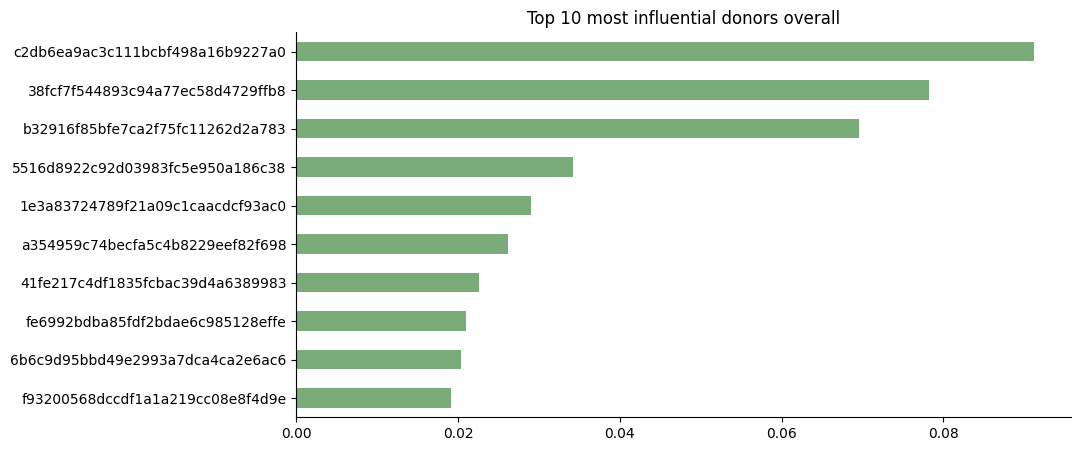

In [30]:
DCfr_full.nlargest(10).sort_values(ascending=True).plot.barh(figsize=(10,5), title='Top 10 most influential donors overall', color=['#79AC78'])

sns.despine(top=True, right=True)
plt.show()

# Degree Centrality (Exciting Projects)

Above is considered the analysis on the overal network of donors, let's assess the same but in this case only for exciting projects.

In [8]:
# Reading outcomes and preparing
dfout = pd.read_csv('Data/outcomes.csv', index_col=[0], usecols=['projectid', 'is_exciting'] ).replace({'t':1, 'f':0}).astype({'is_exciting':'uint8'})

# Merging with edges per project calculated above to obtain the same but only for exciting projects
exciting_donors = (dfout
                   .merge( pr_unique_donors.to_frame(), left_index=True, right_index=True, how='left' )
                   .query("is_exciting == 1")
                   .donor_acctid
                   )

exciting_donors

projectid
ffff2d9c769c8fb5335e949c615425eb    {(af1f03b856fc2979c01a6ad8b61f6fbe, ad64435ac0...
fffe0bb8af3b9cd93046b49653cc923a    {(1733cd1194482cf74f73c4a78a558bda, 8206b365f2...
fffccdc88058ff2ac3ea35881021ef59    {(1ff0e123247046142307165feaa5d468, c329e7d17c...
fffca85fb3541898739575698075a92c    {(a29c2582ca2914bc2a6e53b98f038228, 2a73d74ce0...
fffc602212a37bd35f49c51d2cd6a514    {(081c26a6e09e7822337c4fe07974ffa0, 710e77bb6c...
                                                          ...                        
0005c67e0e193aa0ae005b6bd2c7c1bc    {(7ee2e784cf3f8bdcee5546177d301adc, 804736f32c...
0004ee26667e751dd51384eb9f30c72e    {(f0ea1a27d92017b5f2207d32ef7d083b, 7db3de4df8...
000308a4c89c470812b393ce91cbcb0d    {(d5cb0f656c5f9fd8a0f5a2286992c0f4, eaa5d576b2...
00030653a33d0657cf9ffb494a059a7e    {(bdb25aa9d85aa9e1bbe784e4f590d215, 995c595219...
0001cd238ed6959ff8650888aaf18dce    {(68212e7c9d100da4287bcf1135fcadd3, d65a402648...
Name: donor_acctid, Length: 36710, dtype: ob

In [9]:
# Getting unique donors
exciting_donors_vrtx = set(exciting_donors.index.unique())

# Compiling edges
exciting_edges = []
for _set in exciting_donors.values:
    exciting_edges += list(_set)

# Graph Object Creation
excGr = nx.Graph()

excGr.add_nodes_from(exciting_donors_vrtx)
excGr.add_edges_from(exciting_edges)

* Degree Centrality: Measures the number of edges that connect to a node, in our context it indicates that donors with the highests value of centrality are influential donors in the overall network.

In [31]:
DCfr_exc = pd.Series( nx.degree_centrality(excGr) )

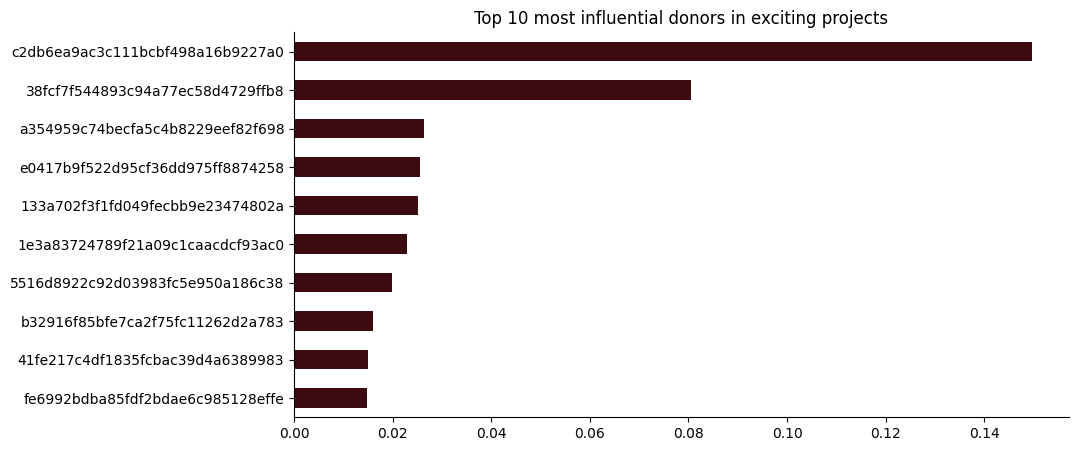

In [34]:
DCfr_exc.nlargest(10).sort_values(ascending=True).plot.barh(figsize=(10,5), title='Top 10 most influential donors in exciting projects', color=['#3D0C11'])

sns.despine(top=True, right=True)
plt.show()

Is noticeable how the centrality metric range between the top 10 most influential donors overall and in exciting projects difer in range. Here a couple of donors noticeably stand out and the remaining 8 stay within a range, this poses the question: **influential donors in exciting projects are more likely to share their findings in their network?**

# Degree Centrality (exciting, not exciting and overall)

Let's compile the top 10k influential donors for projects that recieve donations in each case, and see if there's a difference between these:

In [10]:
# Merging with edges per project calculated above to obtain the same series but now for projects not exciting
not_exciting_donors = (dfout
                        .merge( pr_unique_donors.to_frame(), left_index=True, right_index=True, how='left' )
                        .query("is_exciting == 0")
                        .donor_acctid
                        .dropna()# some project do not get donations!
                        )

# Getting unique donors
not_exciting_donors_vrtx = set(not_exciting_donors.index.unique())

# Compiling edges
not_exciting_edges = []
for _set in not_exciting_donors.values:
    not_exciting_edges += list(_set)

# Graph Object Creation
notexcGr = nx.Graph()
notexcGr.add_nodes_from(not_exciting_donors_vrtx)
notexcGr.add_edges_from(not_exciting_edges)

# Compiling degree centrality
DCfr_NOTexc = pd.Series( nx.degree_centrality(notexcGr) )

Now let's compile the top 10k most influential in each aggregation level scenario (exciting, not_exciting and overall)

In [70]:
# Compiling
TOPN = 10000
dfreport = pd.concat([
                        DCfr_exc.nlargest(TOPN).to_frame().assign( project_type_influence = 'exciting' ),
                        DCfr_NOTexc.nlargest(TOPN).to_frame().assign( project_type_influence = 'not_exciting' ),
                        DCfr_full.nlargest(TOPN).to_frame().assign( project_type_influence = 'overall' ),
                    ]).rename(columns={0:'Degree Centrality'})
dfreport

,Degree Centrality,project_type_influence
c2db6ea9ac3c111bcbf498a16b9227a0,0.149683,exciting
38fcf7f544893c94a77ec58d4729ffb8,0.080589,exciting
a354959c74becfa5c4b8229eef82f698,0.026300,exciting
e0417b9f522d95cf36dd975ff8874258,0.025641,exciting
133a702f3f1fd049fecbb9e23474802a,0.025084,exciting
...,...,...
4ac1e9acb8b32461239517c2f1a71c86,0.000125,overall
4cd4b84019ba58ec7ae0f00267e8a8c1,0.000125,overall
9849027e80dd4a3ae9152f3e23232e20,0.000125,overall
65bef61e9895e67b0b7f7a66f63adc9a,0.000125,overall


Text(0.5, 1.0, 'Most influential donors centrality metric for exciting projects at different levels of aggregation')

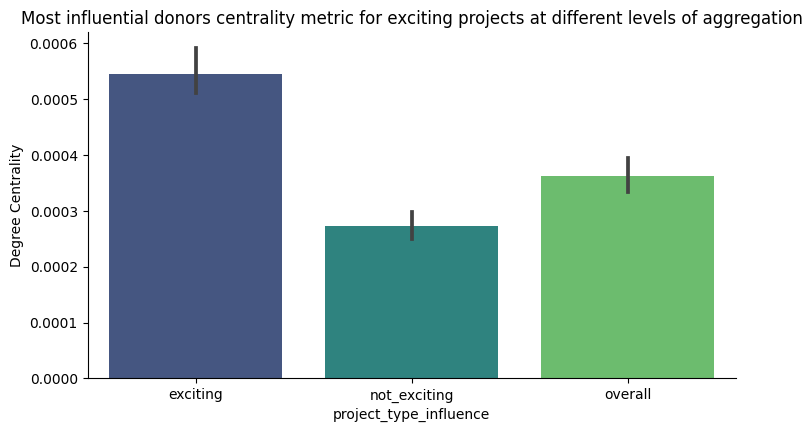

In [77]:
sns.catplot(data=dfreport, x="project_type_influence", y="Degree Centrality", kind="bar", height=4.2, aspect=1.8, palette="viridis")

plt.title('Most influential donors centrality metric for exciting projects at different levels of aggregation')

Therefore it is the case that influential donors in exciting projects are more likely to share their findings with their network and top donors in *not_exciting* projects tend to behave more as "solo" entities.

Finally, we've seen in past notebooks how the donors that are also teachers influence a project excitement, let's visualize this component as well:

In [86]:
# Compiling Teacher IDs
df_teach = (dfdon
                .loc[:, ['donor_acctid', 'is_teacher_acct']]
                .drop_duplicates(subset=['donor_acctid'])
                .set_index('donor_acctid')
                .rename(columns={'is_teacher_acct':'DonorType'})
                .replace({'t':'Teacher', 'f':'Not_a_teacher'})
                .merge(dfreport, left_index=True, right_index=True, how='right')
                )

df_teach.head()

,DonorType,Degree Centrality,project_type_influence
000c8197849c5f4220faf84a8c920f73,Not_a_teacher,0.000222,exciting
000c8197849c5f4220faf84a8c920f73,Not_a_teacher,0.000134,not_exciting
000c8197849c5f4220faf84a8c920f73,Not_a_teacher,0.000188,overall
000d2aaf3c3bd6575bd06caa28e88a0b,Not_a_teacher,0.000358,exciting
000ec992da1a92e02c9a9c5c5b3275af,Not_a_teacher,0.000268,exciting


Text(0.5, 1.0, 'Most influential donors centrality metric for exciting projects by Donor Type at different levels of aggregation')

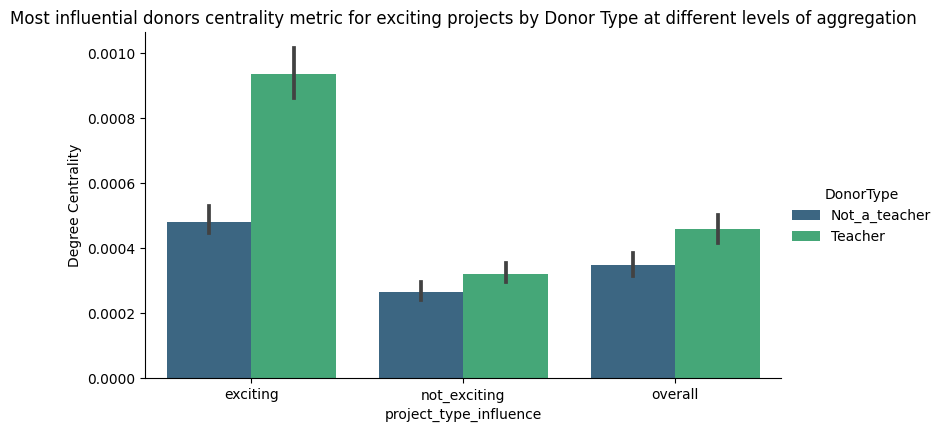

In [88]:
sns.catplot(data=df_teach, x="project_type_influence", y="Degree Centrality", hue="DonorType" ,kind="bar", height=4.2, aspect=1.8, palette="viridis")

plt.title('Most influential donors centrality metric for exciting projects by Donor Type at different levels of aggregation')

# Graphs Representation

Here, just as a complement, is presented a quick overview on the graph representation for each agregation. Since these graphs contain huge number of vertexes and edges, therefore their representation will be done by subsampling them.

In [39]:
import random
def sub_sampling_plot(G, _title, NR_vrtx = 100):
    """
    Sub sampling a graph a representing it in a circular layout
    """

    all_nodes = list(G.nodes)
    selected_nodes = random.sample(all_nodes, k=NR_vrtx)  # Nr of vertexes
    G_subsampled = G.subgraph(selected_nodes) # Subsampling is important because there are many vrtxs and many more edges

    plt.figure(figsize=(10,5))
    # Circular Layout
    pos = nx.circular_layout(G_subsampled)
    # Draw nodes 
    nx.draw_networkx_nodes(G_subsampled, pos, node_size=10, node_color='blue', alpha=0.6)
    # Draw edges
    nx.draw_networkx_edges(G_subsampled, pos, width=0.5, alpha=0.6)

    plt.title(f"{_title} for {NR_vrtx} random vertexes")
    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.show()

* Exciting Donors

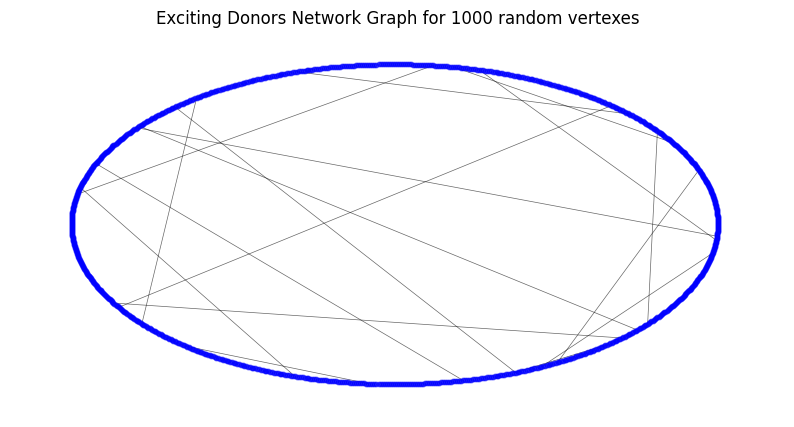

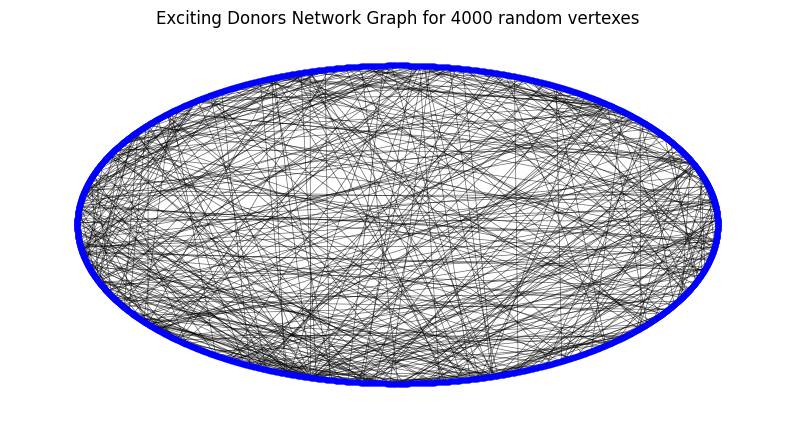

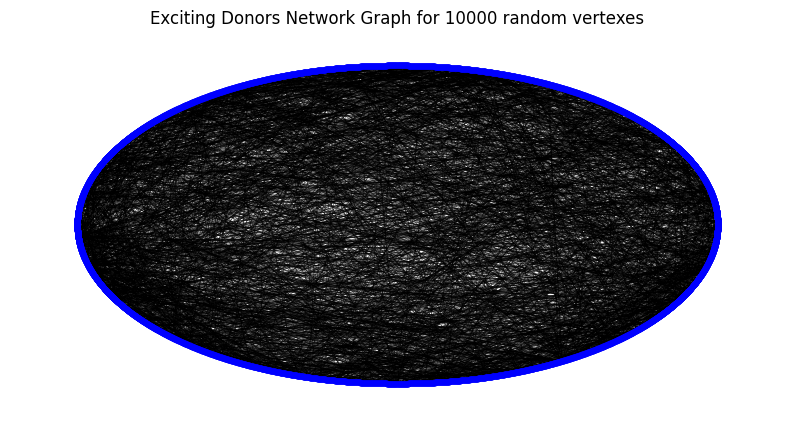

In [40]:
# Representing at different levels
for N in [1000, 4000, 10000]:
    sub_sampling_plot(excGr, 'Exciting Donors Network Graph', NR_vrtx = N)

* Not Exciting Donors

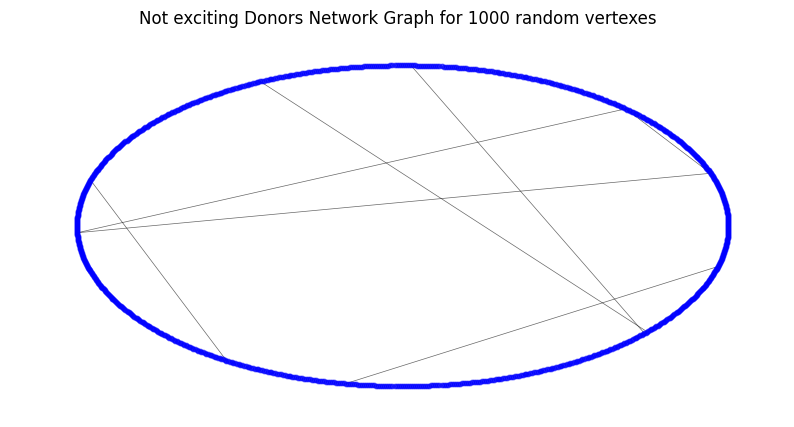

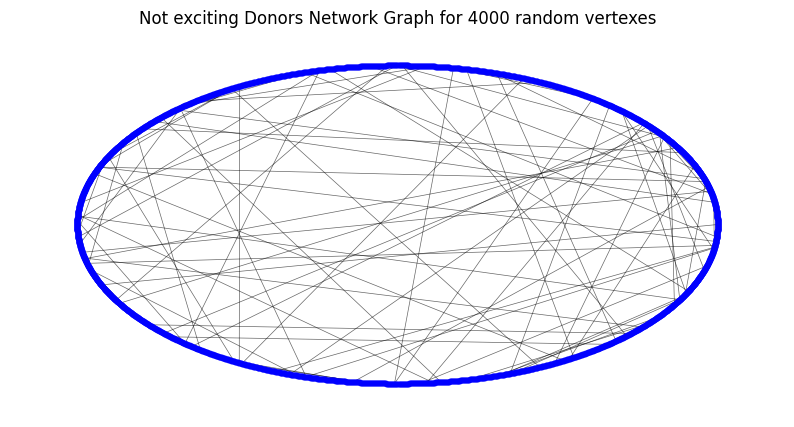

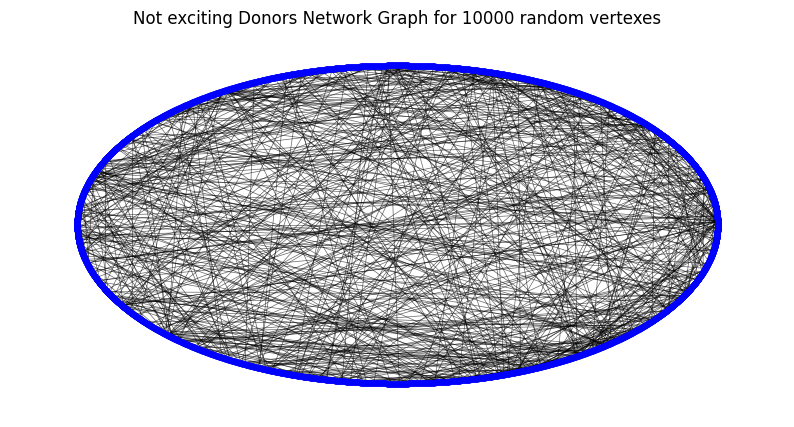

In [41]:
# Representing at different levels
for N in [1000, 4000, 10000]:
    sub_sampling_plot(notexcGr, 'Not exciting Donors Network Graph', NR_vrtx = N)

By representing the graph visually, we can also notice how the conection density is far higher for donors that contribute to exciting projects.